# Traffic accident occurrence prediction task

Author: Baixiang Huang <bhuang15@hawk.iit.edu>, Bryan Hooi <bhooi@comp.nus.edu.sg>, Kai Shu <kshu@iit.edu>

License: GPL3

TAP: A Comprehensive Data Repository for Traffic Accident Prediction in Transportation Networks. Baixiang Huang, Bryan Hooi, Kai Shu.

In [25]:
!pip install osmnx torch_geometric

In [26]:
import os
import math
import time
import shutil
import pickle
import numpy as np
import osmnx as ox
import pandas as pd
import os.path as osp
import networkx as nx
import xgboost as xgb
import matplotlib.pyplot as plt

import torch
import torch_geometric
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from torch import Tensor
from torch.nn import Parameter
from torch_geometric.io import read_npz
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import reset, uniform, zeros
from torch_geometric.typing import OptTensor, OptPairTensor, Adj, Size
from torch_geometric.data import Data, DataLoader, InMemoryDataset, download_url

from pylab import cm
from matplotlib import colors
from IPython.display import clear_output
from xgboost.sklearn import XGBClassifier
from typing import Union, Tuple, Callable, Optional
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import numpy as np
np.random.seed(7)
torch.manual_seed(7)
plt.style.use("ggplot")

In [27]:
print('CUDA version:', torch.version.cuda)
print('PyTorch version:', torch.__version__)
print('PyG version:', torch_geometric.__version__)
print('XGBoost version:', xgb.__version__)
if torch.cuda.is_available():
    # Set the device to the first available CUDA device
    device = torch.device('cuda:0')
    print('Using CUDA device:', torch.cuda.current_device())
else:
    # If CUDA is not available, use CPU
    device = torch.device('cpu')
    print('Using CPU')
device

CUDA version: 12.6
PyTorch version: 2.9.0+cu126
PyG version: 2.7.0
XGBoost version: 3.1.2
Using CUDA device: 0


device(type='cuda', index=0)

In [28]:
us_state_to_abbrev = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID",
    "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
    "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
    "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",
    "Wisconsin": "WI", "Wyoming": "WY", "District of Columbia": "DC", "American Samoa": "AS",
    "Guam": "GU", "Northern Mariana Islands": "MP", "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM", "U.S. Virgin Islands": "VI",
}

us_abbrev_to_state = dict(map(reversed, us_state_to_abbrev.items()))

In [29]:
def read_npz(path):
    with np.load(path, allow_pickle=True) as f:
        return parse_npz(f)


def parse_npz(f):
    crash_time = f['crash_time']
    x = torch.from_numpy(f['x']).to(torch.float)
    coords = torch.from_numpy(f['coordinates']).to(torch.float)
    edge_attr = torch.from_numpy(f['edge_attr']).to(torch.float)
    cnt_labels = torch.from_numpy(f['cnt_labels']).to(torch.long)
    occur_labels = torch.from_numpy(f['occur_labels']).to(torch.long)
    edge_attr_dir = torch.from_numpy(f['edge_attr_dir']).to(torch.float)
    edge_attr_ang = torch.from_numpy(f['edge_attr_ang']).to(torch.float)
    severity_labels = torch.from_numpy(f['severity_8labels']).to(torch.long)
    edge_index = torch.from_numpy(f['edge_index']).to(torch.long).t().contiguous()
    return Data(x=x, y=occur_labels, severity_labels=severity_labels, edge_index=edge_index,
                edge_attr=edge_attr, edge_attr_dir=edge_attr_dir, edge_attr_ang=edge_attr_ang,
                coords=coords, cnt_labels=cnt_labels, crash_time=crash_time)


def train_test_split_stratify(dataset, train_ratio, val_ratio, class_num):
    labels = dataset[0].y
    train_mask = torch.zeros(size=labels.shape, dtype=bool)
    val_mask = torch.zeros(size=labels.shape, dtype=bool)
    test_mask = torch.zeros(size=labels.shape, dtype=bool)
    for i in range(class_num):
        stratify_idx = np.argwhere(labels.numpy() == i).flatten()
        np.random.shuffle(stratify_idx)
        split1 = int(len(stratify_idx) * train_ratio)
        split2 = split1 + int(len(stratify_idx) * val_ratio)
        train_mask[stratify_idx[:split1]] = True
        val_mask[stratify_idx[split1:split2]] = True
        test_mask[stratify_idx[split2:]] = True
    highest = pd.DataFrame(labels).value_counts().head().iloc[0]
    # print("Null Accuracy:", highest / (len(labels)))
    return train_mask, val_mask, test_mask

In [30]:
class TRAVELDataset(InMemoryDataset):
    r"""
    Args:
        root (string): Root directory where the dataset should be saved.
        name (string): The name of the dataset.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    """
    url = 'https://github.com/baixianghuang/travel/raw/main/TAP-city/{}.npz'
    # url = 'https://github.com/baixianghuang/travel/raw/main/TAP-state/{}.npz'

    def __init__(self, root: str, name: str,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        self.name = name.lower()
        super().__init__(root, transform, pre_transform)
        # Set weights_only=False to address the UnpicklingError
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, self.name, 'raw')

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, self.name, 'processed')

    @property
    def raw_file_names(self) -> str:
        return f'{self.name}.npz'

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        download_url(self.url.format(self.name), self.raw_dir)

    def process(self):
        data = read_npz(self.raw_paths[0])
        data = data if self.pre_transform is None else self.pre_transform(data)
        data, slices = self.collate([data])
        torch.save((data, slices), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.name.capitalize()}Full()'

In [31]:
class TRAVELConv(MessagePassing):
    r"""
    Args:
        in_channels (int or tuple): Size of each input sample, or :obj:`-1` to
            derive the size from the first input(s) to the forward method.
            A tuple corresponds to the sizes of source and target
            dimensionalities.
        out_channels (int): Size of each output sample.
        nn (torch.nn.Module): Multiple layers of non-linear transformations
            that maps feature data of shape :obj:`[-1,
            num_node_features + num_edge_features]` to shape
            :obj:`[-1, new_dimension]`, *e.g.*, defined by
            :class:`torch.nn.Sequential`.
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"add"`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add the transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, nn: Callable, aggr: str = 'add',
                 root_weight: bool = True, bias: bool = True, **kwargs):
        super(TRAVELConv, self).__init__(aggr=aggr, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.nn = nn
        self.aggr = aggr

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.in_channels_l = in_channels[0]

        if root_weight:
            self.root = Parameter(torch.Tensor(in_channels[1], out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        reset(self.nn)
        if self.root is not None:
            uniform(self.root.size(0), self.root)
        zeros(self.bias)


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, size: Size = None) -> Tensor:
        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=size)

        x_r = x[1]
        if x_r is not None and self.root is not None:
            out += torch.matmul(x_r, self.root)

        if self.bias is not None:
            out += self.bias
        return out


    def message(self, x_i: Tensor, x_j: Tensor, edge_attr: Tensor) -> Tensor:
        inputs = torch.cat([x_j, edge_attr], dim=1)
        return self.nn(inputs)

    def __repr__(self):
        return '{}({}, {}, aggr="{}", nn={})'.format(self.__class__.__name__,
                                                     self.in_channels,
                                                     self.out_channels,
                                                     self.aggr, self.nn)

In [32]:
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


@torch.no_grad()
def test(model, data):
    model.eval()
    logits, measures = model().detach(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        mea = f1_score(data.y[mask].cpu(), pred.cpu(), average='binary')
        measures.append(mea)

    label_pred = logits.max(1)[1]
    mask = data.test_mask
    scores = logits[mask][:,1]
    pred = logits[mask].max(1)[1]
    test_y = data.y[mask]

    # Các chỉ số cũ
    test_acc = pred.eq(test_y).sum().item() / mask.sum().item()
    test_map = average_precision_score(test_y.cpu(), scores.cpu())
    test_auc = roc_auc_score(test_y.cpu(), scores.cpu())

    # --- PHẦN THÊM MỚI (MAE, RMSE, PCC) ---
    # Chuyển sang numpy array để tính toán
    y_true_np = test_y.cpu().numpy()
    y_pred_np = pred.cpu().numpy()

    test_mae = mean_absolute_error(y_true_np, y_pred_np)
    test_rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
    # Pearsonr trả về (statistic, p-value), ta lấy phần tử [0]
    test_pcc, _ = pearsonr(y_true_np, y_pred_np)
    # --------------------------------------

    return measures, label_pred, test_acc, test_map, test_auc, test_mae, test_rmse, test_pcc


def train_loop(model, data, optimizer, num_epochs, model_name='', city_name=''):
    # Khởi tạo thêm các list để lưu MAE, RMSE, PCC
    epochs, train_measures, valid_measures, test_measures = [], [], [], []
    test_accs, test_maps, test_aucs = [], [], []
    test_maes, test_rmses, test_pccs = [], [], [] # List mới

    for epoch in range(num_epochs):
        train(model, data, optimizer)
        log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'

        # Unpack thêm các giá trị mới trả về từ test()
        measures, label_pred, test_acc, test_map, test_auc, test_mae, test_rmse, test_pcc = test(model, data)

        train_mea, valid_mea, test_mea = measures
        epochs.append(epoch)
        train_measures.append(train_mea)
        valid_measures.append(valid_mea)
        test_measures.append(test_mea)

        # Append các chỉ số vào list
        test_aucs.append(test_auc)
        test_accs.append(test_acc)
        test_maps.append(test_map)
        test_maes.append(test_mae)   # Mới
        test_rmses.append(test_rmse) # Mới
        test_pccs.append(test_pcc)   # Mới

        if epoch % 5 == 0:
            clear_output(True)
            fig, (ax1, ax) = plt.subplots(1, 2, figsize=(30, 12))
            gdf_pred['label'] = label_pred.cpu().numpy()
            for i in range(class_num):
                G = nx.MultiGraph()
                G.add_nodes_from(gdf_pred[gdf_pred['label'] == i].index)
                sub1 = nx.draw(G, pos=pos_dict, ax=ax1, node_color=color_ls[i], node_size=10)

            ax.text(1, 1, log.format(epoch, train_measures[-1], valid_measures[-1], test_measures[-1]), fontsize=18)
            ax.plot(epochs, train_measures, "r", epochs, valid_measures, "g", epochs, test_measures, "b")
            ax.set_ylim([0, 1])
            ax.legend(["train", "valid", "test"])
            ax1.legend(["Negative", "Positive"])
            ax1.set_title(city_name+' '+model_name, y=-0.01)
            plt.show()

    select_idx = np.argmax(valid_measures[num_epochs//2:]) + num_epochs//2

    # Lấy giá trị tại epoch được chọn
    final_test_mea = np.array(test_measures)[select_idx]
    final_test_auc = np.array(test_aucs)[select_idx]
    final_test_acc = np.array(test_accs)[select_idx]
    final_test_map = np.array(test_maps)[select_idx]

    # Lấy giá trị mới
    final_test_mae = np.array(test_maes)[select_idx]
    final_test_rmse = np.array(test_rmses)[select_idx]
    final_test_pcc = np.array(test_pccs)[select_idx]

    print('Selected epoch {}'.format(select_idx))
    # Cập nhật print log
    print('F1 {:.5f} | AUC {:.5f} | Acc {:.5f} | MAP {:.5f} | MAE {:.5f} | RMSE {:.5f} | PCC {:.5f}'.format(
        final_test_mea, final_test_auc, final_test_acc, final_test_map, final_test_mae, final_test_rmse, final_test_pcc))

    # Trả về thêm các giá trị mới (tùy nhu cầu làm tròn hay không, ở đây giữ nguyên format cũ là nhân 100 và làm tròn 2 chữ số)
    # Lưu ý: MAE, RMSE, PCC thường không nhân 100 như Accuracy hay F1, nhưng dưới đây mình để nguyên giá trị gốc cho đúng ý nghĩa.
    return (round(final_test_mea*100, 2),
            round(final_test_auc*100, 2),
            round(final_test_acc*100, 2),
            round(final_test_map*100, 2),
            round(final_test_mae, 4),
            round(final_test_rmse, 4),
            round(final_test_pcc, 4))

In [33]:
# cities_sorted_by_accident.pkl is available in the directory `util` (https://github.com/baixianghuang/travel/tree/main/util)
# with open('cities_sorted_by_accident.pkl', 'rb') as fp:
#     all_city_ls = pickle.load(fp)

# print('# cities:', len(all_city_ls))
# for e in all_city_ls[:50]:
#     print(e[0]+' ('+e[1]+')', end = ', ')
# len(all_city_ls)

## Training

In [34]:
def draw_with_labels(df_nodes, model_name='test'):
    plt.figure(figsize=(6, 5))
    for i in range(class_num):
        G = nx.MultiGraph()
        G.add_nodes_from(df_nodes[df_nodes['label'] == i].index)
        nx.draw(G, pos=pos_dict, node_color=color_ls[i], node_size=3, label=i)
    plt.legend(labels=["Negative", "Positive"], loc="upper right", fontsize='small')
    plt.title(model_name, y=-0.01)
    plt.show()


d=16
p=0.5
all_res = []
color_ls = []
class_num = 2
num_epochs = 301
file_path = 'exp/'
cmap = cm.get_cmap('cool', class_num)
for i in range(class_num):
    rgba = cmap(i)
    color_ls.append(colors.rgb2hex(rgba))

/tmp/ipython-input-128750945.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('cool', class_num)


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

lr_model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    n_jobs=-1
)

nb_model = GaussianNB()

class MLP(nn.Module):
    def __init__(self, hidden_dim=d):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(dataset.num_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, dataset.num_classes)

    def forward(self):
        x = F.relu(self.fc1(data.x))
        x = F.dropout(x, p=p, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


class GCN(torch.nn.Module):
    def __init__(self, hidden_dim=d):
        super(GCN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(dataset.num_features, hidden_dim)
        self.conv2 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, dataset.num_classes)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=p, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

class TRAVELNet(torch.nn.Module):
    def __init__(self, dim=d):
        super(TRAVELNet, self).__init__()
        convdim = 8
        self.node_encoder = nn.Sequential(nn.Linear(data.x.size(-1), dim), nn.LeakyReLU(), nn.Linear(dim, dim))
        self.edge_encoder_dir = nn.Sequential(nn.Linear(data.component_dir.size(-1), dim), nn.LeakyReLU(), nn.Linear(dim, dim))
        self.edge_encoder_ang = nn.Sequential(nn.Linear(data.component_ang.size(-1), dim), nn.LeakyReLU(), nn.Linear(dim, dim))
        nn1 = nn.Sequential(nn.Linear(dim + dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, convdim))
        self.conv1 = TRAVELConv(dim, convdim, nn1)
        nn2 = nn.Sequential(nn.Linear(2*convdim + dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, dataset.num_classes))
        self.conv2 = TRAVELConv(2*convdim, dataset.num_classes, nn2)
        self.bn1 = nn.BatchNorm1d(convdim*2)
        nn1_2 = nn.Sequential(nn.Linear(dim + dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, convdim))
        self.conv1_2 = TRAVELConv(dim, convdim, nn1_2)
        nn2_2 = nn.Sequential(nn.Linear(2*convdim + dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, dataset.num_classes))
        self.conv2_2 = TRAVELConv(2*convdim, dataset.num_classes, nn2_2)
        self.bn2 = nn.BatchNorm1d(dataset.num_classes*2)
        self.fc = nn.Linear(dataset.num_classes*2, dataset.num_classes)

    def forward(self):
        x, edge_index = self.node_encoder(data.x), data.edge_index
        edge_attr_dir, edge_attr_ang = self.edge_encoder_dir(data.component_dir), self.edge_encoder_ang(data.component_ang)
        x1 = F.relu(self.conv1(x, edge_index, edge_attr_dir))
        x2 = F.relu(self.conv1_2(x, edge_index, edge_attr_ang))
        x = torch.cat((x1, x2), axis=1)
        x = self.bn1(x)
        x = F.dropout(x, p=p, training=self.training)
        x1 = F.relu(self.conv2(x, edge_index, edge_attr_dir))
        x2 = F.relu(self.conv2_2(x, edge_index, edge_attr_ang))
        x = torch.cat((x1, x2), axis=1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


# class TRAVELAng(torch.nn.Module):
#     def __init__(self, dim=d):
#         super(TRAVELAng, self).__init__()
#         self.node_encoder = nn.Sequential(nn.Linear(data.x.size(-1), dim), nn.LeakyReLU(), nn.Linear(dim, dim))
#         self.edge_encoder_ang = nn.Sequential(nn.Linear(data.component_ang.size(-1), dim), nn.LeakyReLU(), nn.Linear(dim, dim))
#         nn1 = nn.Sequential(nn.Linear(dim+dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim))
#         self.conv1 = TRAVELConv(dim, dim, nn1)
#         self.bn1 = nn.BatchNorm1d(dim)
#         nn2 = nn.Sequential(nn.Linear(dim+dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim))
#         self.conv2 = TRAVELConv(dim, dim, nn2)
#         self.fc = nn.Linear(dim, dataset.num_classes)

#     def forward(self):
#         x, edge_index = self.node_encoder(data.x), data.edge_index
#         edge_attr_encoded = self.edge_encoder_ang(data.component_ang)
#         x = F.relu(self.conv1(x, edge_index, edge_attr_encoded))
#         x = self.bn1(x)
#         x = F.dropout(x, p=p, training=self.training)
#         x = F.relu(self.conv2(x, edge_index, edge_attr_encoded))
#         x = self.fc(x)
#         return F.log_softmax(x, dim=1)

# class TRAVELDir(torch.nn.Module):
#     def __init__(self, dim=d):
#         super(TRAVELDir, self).__init__()
#         self.node_encoder = nn.Sequential(nn.Linear(data.x.size(-1), dim), nn.LeakyReLU(), nn.Linear(dim, dim))
#         self.edge_encoder_dir = nn.Sequential(nn.Linear(data.component_dir.size(-1), dim), nn.LeakyReLU(), nn.Linear(dim, dim))
#         nn1 = nn.Sequential(nn.Linear(dim+dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim))
#         self.conv1 = TRAVELConv(dim, dim, nn1)
#         self.bn1 = nn.BatchNorm1d(dim)
#         nn2 = nn.Sequential(nn.Linear(dim+dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim), nn.LeakyReLU(), nn.Linear(dim, dim))
#         self.conv2 = TRAVELConv(dim, dim, nn2)
#         self.fc = nn.Linear(dim, dataset.num_classes)

#     def forward(self):
#         x, edge_index = self.node_encoder(data.x), data.edge_index
#         edge_attr_encoded = self.edge_encoder_dir(data.component_dir)
#         x = F.relu(self.conv1(x, edge_index, edge_attr_encoded))
#         x = self.bn1(x)
#         x = F.dropout(x, p=p, training=self.training)
#         x = F.relu(self.conv2(x, edge_index, edge_attr_encoded))
#         x = self.fc(x)
#         return F.log_softmax(x, dim=1)

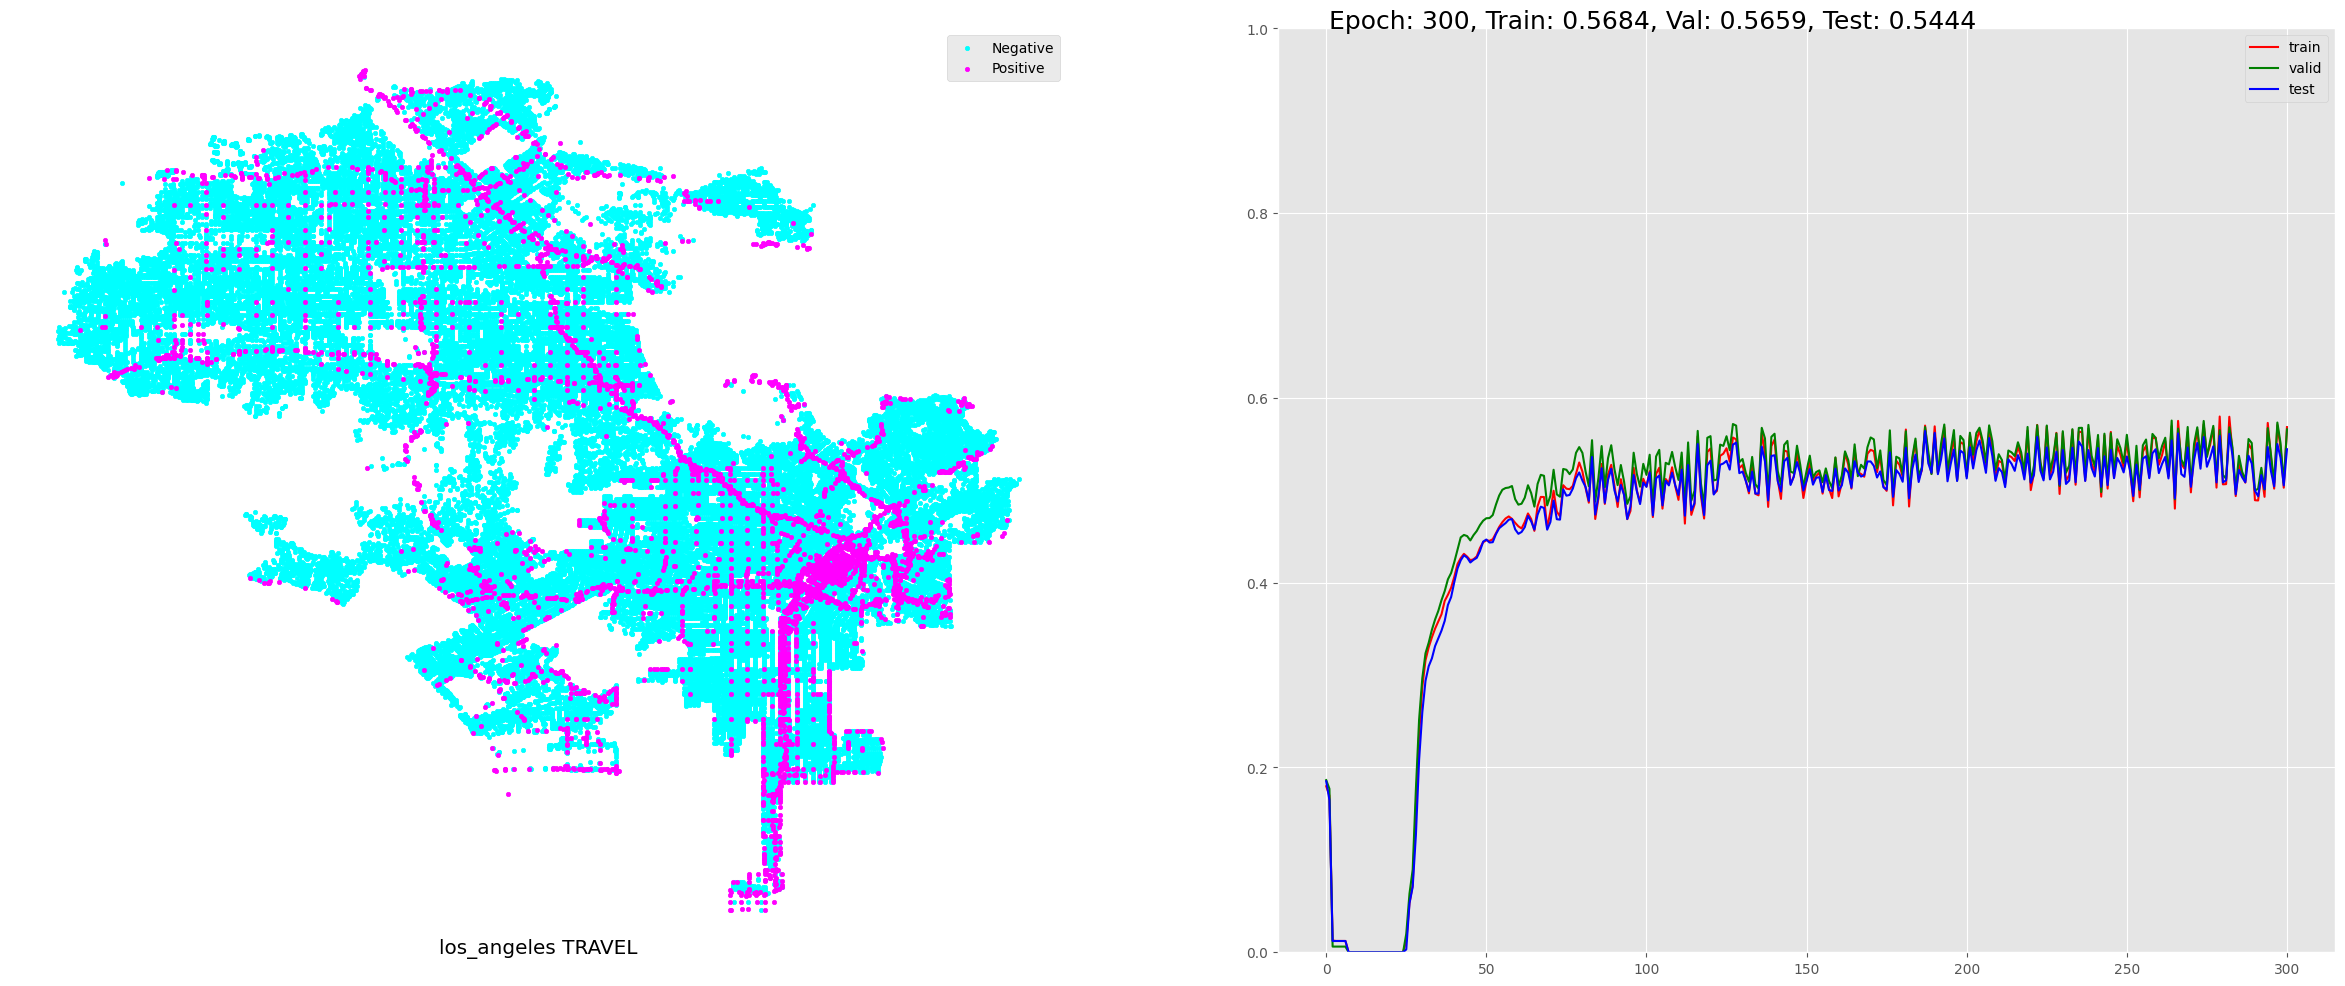

Selected epoch 264
F1 0.55402 | AUC 0.86003 | Acc 0.90196 | MAP 0.56377 | MAE 0.09804 | RMSE 0.31312 | PCC 0.51209
Execution time: 52.9700 seconds
CPU times: user 2min 23s, sys: 1.44 s, total: 2min 25s
Wall time: 2min 37s


In [36]:
%%time
# Đảm bảo đã import các thư viện tính toán metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

# for e in [('Miami', 'Florida')]:
for e in [('Los Angeles', 'California')]:
    city_name, state_abbrev = e[0].lower().replace(" ", "_"), us_state_to_abbrev[e[1]].lower()
    city_format = e[0]+' ('+us_state_to_abbrev[e[1]]+')'
    if os.path.exists(file_path+city_name+'_'+state_abbrev+'/processed'):
        shutil.rmtree(file_path+city_name+'_'+state_abbrev+'/processed')
    dataset = TRAVELDataset(file_path, city_name+'_'+state_abbrev)
    data = dataset[0]
    class_num = dataset.num_classes
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of node features: {dataset.num_features}')
    print(f'Number of edge features: {dataset.num_edge_features}')
    print(f'Number of classes: {dataset.num_classes}')
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
    print(f'Contains self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

    # 60%, 20% and 20% for training, validation and test
    data.train_mask, data.val_mask, data.test_mask = train_test_split_stratify(dataset, train_ratio=0.6, val_ratio=0.2, class_num=class_num)
    sc = MinMaxScaler()
    data.x[data.train_mask] = torch.tensor(sc.fit_transform(data.x[data.train_mask]), dtype=torch.float)
    data.x[data.val_mask] = torch.tensor(sc.transform(data.x[data.val_mask]), dtype=torch.float)
    data.x[data.test_mask] = torch.tensor(sc.transform(data.x[data.test_mask]), dtype=torch.float)

    edge_attr_all = MinMaxScaler().fit_transform(data.edge_attr.cpu())
    edge_attr_all = torch.tensor(edge_attr_all).float().to(device)

    coords = data.coords.numpy()
    print(len(coords))
    print(coords[:5])
    print(len(data.x.numpy()))
    print(data.y.numpy())
    gdf_pred = pd.DataFrame({'x': coords[:, 0], 'y': coords[:, 1], 'label': data.y.numpy()})
    zip_iterator = zip(gdf_pred.index, gdf_pred[['x', 'y']].values)
    pos_dict = dict(zip_iterator)
    draw_with_labels(gdf_pred, 'Ground Truth')

    X_train, X_test, y_train, y_test = data.x[data.train_mask].cpu().numpy(), data.x[data.test_mask].cpu().numpy(), data.y[data.train_mask].cpu().numpy(), data.y[data.test_mask].cpu().numpy()
    start_time = time.time()
    xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb_clf.fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)

    # --- CẬP NHẬT PHẦN XGBOOST ---
    test_acc = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='binary')
    test_map = average_precision_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_pred)

    # Tính thêm metrics mới
    test_mae = mean_absolute_error(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_pcc, _ = pearsonr(y_test, y_pred)

    print('f1_score {:.5f} | AUC {:.5f} | Test Accuracy {:.5f} | MAP {:.5f} | MAE {:.5f} | RMSE {:.5f} | PCC {:.5f}'.format(
        test_f1, test_auc, test_acc, test_map, test_mae, test_rmse, test_pcc))

    # Cập nhật res để bao gồm 7 giá trị (đồng bộ với train_loop)
    res = (round(test_f1*100, 2), round(test_auc*100, 2), round(test_acc*100, 2), round(test_map*100, 2),
           round(test_mae, 4), round(test_rmse, 4), round(test_pcc, 4))
    # -----------------------------

    t = round(time.time() - start_time, 2)
    all_res.append((city_format,) + ('XGBoost',) + res + (t,))
    print("Execution time: %.4f seconds" % t)

    data = data.to(device)

    start_time = time.time()
    # Fix: RandomForestClassifier is a scikit-learn model and does not have a .to() method.
    # Remove .to(device) as it runs on CPU by default.
    model = rf_model
    # For scikit-learn models, training is typically done with .fit() and not an optimizer loop.
    # Since train_loop expects a PyTorch model and optimizer, this section needs re-evaluation
    # if RandomForest is intended to be used in the same training loop structure.
    # For now, we will comment out the train_loop call for rf_model to resolve the AttributeError.
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    # res = train_loop(model, data, optimizer, num_epochs, 'MLP', city_name)

    # If you want to use RandomForestClassifier, it should be trained like this:
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = data.x[data.train_mask].cpu().numpy(), data.x[data.test_mask].cpu().numpy(), data.y[data.train_mask].cpu().numpy(), data.y[data.test_mask].cpu().numpy()
    rf_model.fit(X_train_rf, y_train_rf)
    y_pred_rf = rf_model.predict(X_test_rf)
    rf_test_f1 = f1_score(y_test_rf, y_pred_rf, average='binary')
    rf_test_auc = roc_auc_score(y_test_rf, y_pred_rf)
    rf_test_acc = accuracy_score(y_test_rf, y_pred_rf)
    rf_test_map = average_precision_score(y_test_rf, y_pred_rf)
    rf_test_mae = mean_absolute_error(y_test_rf, y_pred_rf)
    rf_test_rmse = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
    rf_test_pcc, _ = pearsonr(y_test_rf, y_pred_rf)
    res = (round(rf_test_f1*100, 2), round(rf_test_auc*100, 2), round(rf_test_acc*100, 2), round(rf_test_map*100, 2),
           round(rf_test_mae, 4), round(rf_test_rmse, 4), round(rf_test_pcc, 4))
    t = round(time.time() - start_time, 2)
    all_res.append((city_format,) + ('RandomForest',) + res + (t,))
    print("Execution time: %.4f seconds" % t)

    # To continue with the PyTorch models, ensure 'model' is a PyTorch module.
    # The line `model = rf_model` was replaced with `model = MLP().to(device)` to run MLP.
    # Assuming the original intent was to run MLP after XGBoost, not RandomForest with the same loop.

    # Re-introducing MLP with its correct setup
    model = MLP().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    res = train_loop(model, data, optimizer, num_epochs, 'MLP', city_name)
    t = round(time.time() - start_time, 2)
    all_res.append((city_format,) + ('MLP',) + res + (t,))
    print("Execution time: %.4f seconds" % t)

    data = data.to(device)
    start_time = time.time()
    model = GCN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    res = train_loop(model, data, optimizer, num_epochs, 'GCN', city_name)
    t = round(time.time() - start_time, 2)
    all_res.append((city_format,) + ('GCN',) + res + (t,))
    print("Execution time: %.4f seconds" % t)

    # start_time = time.time()
    # model = ChebNet().to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)
    # res = train_loop(model, data, optimizer, num_epochs, 'ChebNet', city_name)
    # t = round(time.time() - start_time, 2)
    # all_res.append((city_format,) + ('ChebNet',) + res + (t,))
    # print("Execution time: %.4f seconds" % t)

    # start_time = time.time()
    # model = ARMANet().to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)
    # res = train_loop(model, data, optimizer, num_epochs, 'ARMANet', city_name)
    # t = round(time.time() - start_time, 2)
    # all_res.append((city_format,) + ('ARMANet',) + res + (t,))
    # print("Execution time: %.4f seconds" % t)

    # start_time = time.time()
    # model = GraphSAGE().to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=5e-4)
    # res = train_loop(model, data, optimizer, num_epochs, 'GraphSAGE', city_name)
    # t = round(time.time() - start_time, 2)
    # all_res.append((city_format,) + ('GraphSAGE',) + res + (t,))
    # print("Execution time: %.4f seconds" % t)

    # start_time = time.time()
    # model = TAGCN().to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    # res = train_loop(model, data, optimizer, num_epochs, 'TAGCN', city_name)
    # t = round(time.time() - start_time, 2)
    # all_res.append((city_format,) + ('TAGCN',) + res + (t,))
    # print("Execution time: %.4f seconds" % t)

    # start_time = time.time()
    # model = GIN().to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    # res = train_loop(model, data, optimizer, num_epochs, 'GIN', city_name)
    # t = round(time.time() - start_time, 2)
    # all_res.append((city_format,) + ('GIN',) + res + (t,))
    # print("Execution time: %.4f seconds" % t)

    # start_time = time.time()
    # model = GAT().to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.007, weight_decay=5e-4)
    # res = train_loop(model, data, optimizer, num_epochs, 'GAT', city_name)
    # t = round(time.time() - start_time, 2)
    # all_res.append((city_format,) + ('GAT',) + res + (t,))
    # print("Execution time: %.4f seconds" % t)

    # start_time = time.time()
    # model = MPNN().to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    # res = train_loop(model, data, optimizer, num_epochs, 'MPNN', city_name)
    # t = round(time.time() - start_time, 2)
    # all_res.append((city_format,) + ('MPNN',) + res + (t,))
    # print("Execution time: %.4f seconds" % t)

    # start_time = time.time()
    # model = CGC().to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.015, weight_decay=5e-4)
    # res = train_loop(model, data, optimizer, num_epochs, 'CGC', city_name)
    # t = round(time.time() - start_time, 2)
    # all_res.append((city_format,) + ('CGC',) + res + (t,))
    # print("Execution time: %.4f seconds" % t)

    # start_time = time.time()
    # model = GraphTransformer().to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    # res = train_loop(model, data, optimizer, num_epochs, 'Transformer', city_name)
    # t = round(time.time() - start_time, 2)
    # all_res.append((city_format,) + ('Transformer',) + res + (t,))
    # print("Execution time: %.4f seconds" % t)

    # start_time = time.time()
    # model = GEN().to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=5e-4)
    # res = train_loop(model, data, optimizer, num_epochs, 'GEN', city_name)
    # t = round(time.time() - start_time, 2)
    # all_res.append((city_format,) + ('GEN',) + res + (t,))
    # print("Execution time: %.4f seconds" % t)

    # Note that directional and angular edge features are precomputed in our datasets
    component_dir = np.concatenate((data.edge_attr.cpu(), data.edge_attr_dir.cpu()), axis=1)
    component_ang = np.concatenate((data.edge_attr.cpu(), data.edge_attr_ang.cpu()), axis=1)
    component_dir = StandardScaler().fit_transform(component_dir)
    component_ang = StandardScaler().fit_transform(component_ang)
    data.component_dir = torch.tensor(component_dir).float().to(device)
    data.component_ang = torch.tensor(component_ang).float().to(device)

    start_time = time.time()
    model = TRAVELNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    res = train_loop(model, data, optimizer, num_epochs, 'TRAVEL', city_name)
    t = round(time.time() - start_time, 2)
    all_res.append((city_format,) + ('TRAVEL',) + res + (t,))
    print("Execution time: %.4f seconds" % t)

#     start_time = time.time()
#     model = TRAVELAng().to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.006, weight_decay=5e-4)
#     res = train_loop(model, data, optimizer, num_epochs, 'TRAVEL-ang')
#     t = round(time.time() - start_time, 2)
#     all_res.append((city_format,) + ('TRAVEL-ang',) + res + (t,))
#     print("Execution time: %.4f seconds" % t)

#     start_time = time.time()
#     model = TRAVELDir().to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.006, weight_decay=5e-4)
#     res = train_loop(model, data, optimizer, num_epochs, 'TRAVEL-dir')
#     t = round(time.time() - start_time, 2)
#     all_res.append((city_format,) + ('TRAVEL-dir',) + res + (t,))
#     print("Execution time: %.4f seconds" % t)

In [37]:
# Cập nhật thêm cột MAE, RMSE, PCC vào danh sách columns
df = pd.DataFrame(all_res, columns=['City', 'Method', 'F1', 'AUC', 'Acc', 'MAP', 'MAE', 'RMSE', 'PCC', 'Time'])

print('# datasets:', df.shape[0] // len(df.Method.unique()))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df)

# datasets: 1
               City        Method     F1    AUC    Acc    MAP     MAE    RMSE  \
0  Los Angeles (CA)       XGBoost  17.42  54.69  87.87  19.29  0.1213  0.3483   
1  Los Angeles (CA)  RandomForest  17.40  54.68  87.86  19.24  0.1214  0.3484   
2  Los Angeles (CA)           MLP   0.00  66.02  86.98  25.05  0.1302  0.3609   
3  Los Angeles (CA)           GCN  39.69  80.05  89.76  52.72  0.1024  0.3200   
4  Los Angeles (CA)        TRAVEL  55.40  86.00  90.20  56.38  0.0980  0.3131   

      PCC   Time  
0  0.2467   0.19  
1  0.2456   2.49  
2     NaN  57.32  
3  0.4350  45.32  
4  0.5121  52.97  
